# Setting things up

If you have not already, we will need to make sure the latest version of POSYDON is installed and that your have the POSYDON v2 data set downloaded in order to run these labs. Please follow our [installation guide](https://posydon.org/POSYDON/latest/getting-started/installation-guide.html) to install POSYDON and also download the data. In addition, you will need the populations that were created for some of the examples you will encounter in these labs too. You can get that by running

```bash
get-posydon-data 2025_school_data
```

in a terminal command line after you have installed POSYDON. These labs should work with POSYDON v2.1.6 and later versions.

<div class='alert alert-info'>

**Note:** Some of the exercies in these labs will ask you to submit jobs on a high performance computing environment. During the school itself we used Northwestern's Quest computing facilities. Of course, if you do not have access to these you may need to adapt things to fit your own HPC facility's infrastructure. If you need assistance with any of this or the installation, please reach out on Github by [submitting an issue](https://github.com/POSYDON-code/POSYDON-2025-School-Labs/issues) and we will assist further.

# Lab 1: Run a default population

In this lab we will learn how to create a basic binary population with POSYDON. To do that, we are going to need to know the basic ingredients of a population as far as POSYDON is concerned.

Goals:

- Understand the ingredients that go into running a POSYDON population
    + What is the flow chart?
    + What is an evolution step?
    + What are star states and binary events?
- Run a basic binary population of your own
- Analyze one binary from your population and understand its evolution history
- End point: be able to submit a SLURM script to run a population
___

# 1. POSYDON's default flow:

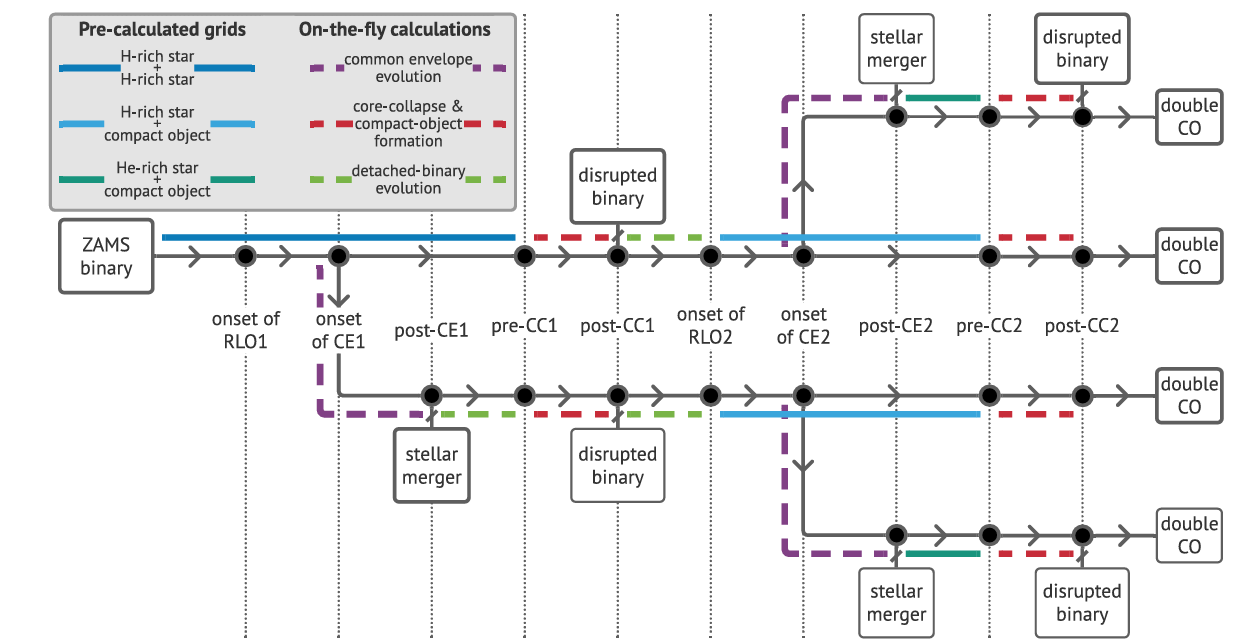

## 1.1 What is the flow chart?
The flow, or `flow_chart` is used by POSYDON to decide where to send a binary system in the course of its evolution. Each colored line corresponds to a different step (with solid involving the `MESA` grids and dashed relying on analytical calculations).

+ <span style="color:#408bc3;">**Dark Blue**</span> &#8594; `step_HMS_HMS` (`MESA`)
+ <span style="color:#66ade2;">**Light Blue**</span> &#8594; `step_CO_HMS_RLO` (`MESA`)
+ <span style="color:#26af6c;">**Teal**</span> &#8594; `step_CO_HeMS`/`step_CO_HeMS_RLO` (`MESA`)
+ <span style="color:#7729b0;">**Purple**</span> &#8594; `step_CE` (analytical)
+ <span style="color:#ef4951;">**Red**</span> &#8594; `step_SN` (analytical)
+ <span style="color:#27cb46;">**Green**</span> &#8594; `step_detached` (analytical, but using single star `MESA` tracks...more on that later in the week)

Each of the black dots in the diagram marks an event, like the onset of Roche lobe overflow for star 1 (RLO1) in the binary. For example, a ZAMS binary first evolves along `step_HMS_HMS` until it either encounters a common envelope or the core collapse of its primary star. Then, the binary gets directed to continue its evolution via analytic calculations in either <code style="color:#7729b0;">step_CE</code> or <code style="color:#ef4951;">step_SN</code> accordingly.

In order to run a binary star population, we need to use a `flow_chart`, or else POSYDON will not know how to link the various events that can happen during a binary star's life into a full evolution history. Let's import and examine POSYDON's default `flow_chart` -- we'll need it in a little bit in order to run a binary population.

In [ ]:
# Import POSYDON's default flow_chart function and call it
from posydon.binary_evol.flow_chart import flow_chart

# We'll store the default flow_chart here to take a closer look at what it is
default_flow = flow_chart()

If you check the `type` of our `default_flow`, you can see that it is a Python `dictionary`.

In [ ]:
type(default_flow)

Before moving on, we will spend a bit of time understanding what this `dictionary` contains because it will be crucial to understanding how POSYDON simulates binary evolution in a population.

## 1.2 Ingredients of the flow: States and Events

The keys of this `dictionary` are tuples that represent the full state of the binary, schematically, it looks like this:

```
full_state = (star_1_state, star_2_state, binary_state, binary_event)
```
As we go along, we will get a better sense for what each of these things means, but briefly:

- `star_1_state`/`star_2_state`: describes the chemical composition of the stellar envelope and core burning state, or the compact object type if the star has evolved to that state.
- `binary_state`: describes the state of the binary, for example, `detached` if neither binary is filling its Roche lobe, or `contact` if both stars are simultaneously roche lobe overflowing.
- `binary_event`: describes what event just occurred, such as ZAMS (usually the first event), oRLO1 (the onset of Roche lobe overflow from star 1), etc.

If you are interested in seeing more examples of the star and binary states, and binary events, you can import lists that contain them from `posydon.binary_evol.flow_chart` like this:

In [ ]:
from posydon.binary_evol.flow_chart import (STAR_STATES_ALL, BINARY_STATES_ALL, BINARY_EVENTS_ALL)

# For example, printing out the star states to have a look:
print(STAR_STATES_ALL)

We have a handy diagram from the POSYDON v1 paper that summarizes how a stellar state is determined, based on the star's composition and nuclear burning state:

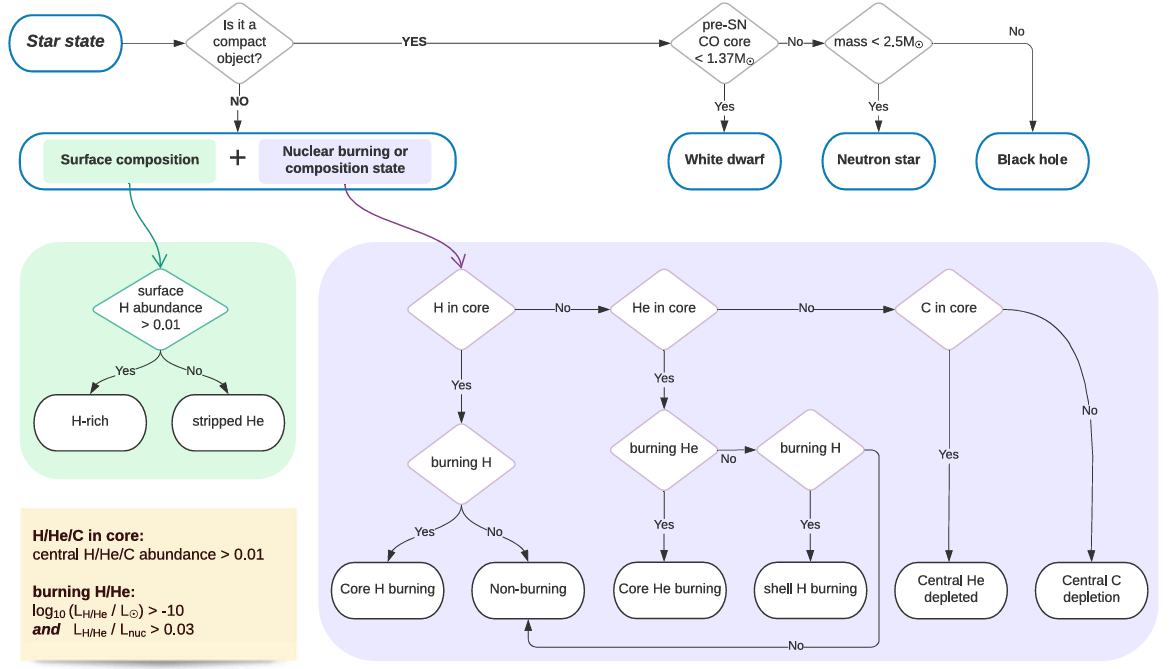

You may want to refer back to this diagram later on if you're ever curious about interpreting the physical meaning of a star's `state` when you are analyzing your binaries from a population run. The binary itself has its own chain of logic (not shown above) that is used to determine its own `state` as well, based usually on criteria that say whether the stars are Roche lobe filling, their mass transfer rates are above a certain threshold conducive to a common envelope, or if they have reached the end of nuclear burning, initiating a core collapse event.

This combination of stellar and binary `state` properties and a binary `event` is what we can expect to see for the `keys` of the `flow_chart` dictionary. Let's have a look at one of them to see this all in action.

In [ ]:
# Print out the first key in the default flow chart as an example:

print(list(default_flow.keys())[0])

<div class='alert alert-success'>

#### Exercise 1: Understanding star states

The binary state and event above might be self-explanatory, but the star states could be a little more difficult to understand.

(a) What is the state of star 1, star 2, the binary, and the binary event in this example?  
(b) Based on the star state diagram above, describe the basic physical properties of each star.

</div>

In [ ]:
# You can write here in this cell if you would like, or feel free to create a Markdown cell to jot things down in too!


<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>
(a) The event and states are:

- H-rich_Core_H_burning
- H-rich_Core_H_burning
- detached
- ZAMS

(b) Both stars are H-rich and core H-burning, meaning that they have a surface H abundance greater than 0.01, a core H abundance greater than 0.01, and a (log) hydrogen burning luminosity greater than -10 plus the H burning luminosity is greater than 3% of the total nuclear burning luminosity.

</details>
</div>

### 1.2.1 Ingredients of the flow: Evolution Steps

The other important building blocks in POSYDON's binary evolution algorithm are its evolution steps.

#### POSYDON's Evolution Steps
___

+ `step_mesa`:
  - this step uses the `MESA` stellar evolution grids (either the `HMS-HMS`, `CO-HMS`, `CO-HeMS`, `CO_HMS_RLO`, or `CO_HeMS_RLO` grid) to further evolve a binary system. If directed here, POSYDON's initial-final interpolators are used to determine the outcome of binary evolution based on pre-calcuted results from `MESA`.
+ `step_detached`:
  - this step is used to further evolve a detached, non-interacting binary. If the binary experiences RLO, this step ends, and the binary is directed to `step_mesa` to further evolve the binary through the interaction.
+ `step_CE`:
  - if a binary system happens to enter a common envelope, neither `step_mesa` nor `step_detached` can handle the evolution. Instead, analytic calculations are used to determine the outcome and further evolve the binary.
+ `step_SN`:
  - Once a `HMS` or `HeMS` star reaches the end of its life, the binary is directed to this step to determine the outcome and what type of compact object the star becomes. If there is a supernova, the binary can become kicked and disrupted as well; this step calculates how the orbit is altered by the explosion.
+ `step_disrupted`:
  - If a binary system is disrupted after a supernova, it could leave behind a single `HMS` or `HeMS` star. These stars are directed to this step to continue their evolution as isolated single stars.
+ `step_merged`:
  - As a result of either inspiral due to angular momentum loss or common envelope, two stellar objects in a binary system can merge into a single object. This step handles how the merger process is treated and what the outcome is.
+ `step_dco`:
  - After both stars have finished nuclear burning and become compact objects, they may still be bound to each other. This step handles the evolution of two bound compact objects.
+ `step_end`:
  - After all steps have completed evolution and the binary has no where left to go, the evolution is considered "done" and the system is directed here to terminate.

___

In the `flow_chart` `dictionary`, every full state `tuple` is mapped to an evolution step. Let's have a look at which step the example `tuple` from above is mapped to.



In [ ]:
# Print out the first item in the default flow chart as an example, to see what the key we looked at before is mapped to:

print(list(default_flow.items())[0])

So you can see that our first `tuple` is mapped to `step_HMS_HMS`. This example state/step combo in the `flow_chart` that we have been examining represents what is usually the first step in binary evolution within POSYDON and it is the first chain in the `flow_chart` visualized in the figure above (CITE FIG?). Putting it all together, what this part of the `flow_chart` says is that if two Hydrogen main sequence stars are detached and at ZAMS, then direct their evolution to use `step_HMS_HMS`. 

Each evolution step is a little bit different, and we will learn about each of them in more detail as the week goes on. Just to give you an idea though, `step_HMS_HMS` is one of several instances of the `mesa_step` within POSYDON. These steps use the pre-computed MESA grids to determine the outcome of binary evolution, until one of the star either stops core nuclear burning, or enters an unstable mass transfer event, such as entering a common envelope or contact state. `MESA` can do many things, but it has limitations; it can not simulate common envelope or contact binary systems for example, so POSYDON checks the `flow_chart` again at the end of `step_HMS_HMS` and figures out where the binary should go next. In POSYDON, binaries will typically either end up in a common envelope, or one of the stars in the binary will core collapse and produce a supernova, turning into a compact object as a result of `step_HMS_HMS`. So, we can expect that the next step following this initial evolution will be either:

1. `step_SN`: if the binary either never transferred mass or has stable mass transfer. In this case, star 1 (the more massive one) will be able to "complete" its evolution and become a compact object eventually.
2. `step_CE`: if the binary experience unstable mass transfer, such as an exceptionally high mass transfer rate or contact occurs (i.e., both stars fill their Roche lobes at the same time).

<div class='alert alert-success'>
    
#### Exercise 2: Next Steps

Change `star_1_state`, `star_2_state`, `binary_state`, and `binary_event` below to try and come up with a combination in the `flow_chart` that could happen as a result of two hydrogen main sequence stars evolving through `step_HMS_HMS`. Our goal is to find out what the next steps in the flow chart could be, so find a combination that leads to either `step_CE` or `step_SN`.
    
</div>

In [ ]:
# Change the states and events to see if you can find a combo that
# is mapped to either `step_CE`, `step_detached`, or `step_disrupted`

star_1_state = ### Fill this in ###
star_2_state = ### Fill this in ###
binary_state = ### Fill this in ###
binary_event = ### Fill this in ###

full_state = (star_1_state, star_2_state, binary_state, binary_event)
print("For the full state: ", full_state)
print("The next step is: ", default_flow[full_state])

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint 1 (click to reveal):</summary></b>

Remember that you can print these lists to see all of the valid star states, binary states, and binary events.
  
```python
print(STAR_STATES_ALL)
print(BINARY_STATES_ALL)
print(BINARY_EVENTS_ALL)
```

</details>

<div class="alert alert-warning">
<details>

<b><summary>Hint 2 (click to reveal):</summary></b>

To get a core collapse event (`CC1` or `CC2`), a star needs to have a depleted core.

</details>
</div>

<div class="alert alert-warning">
<details>

<b><summary>Hint 3 (click to reveal):</summary></b>

  A `MESA` evolution step will end if unstable roche lobe overflow starts. This is typically marked by the event `oCE1` (for the onset of common envelope from star 1) or `oCE2`.

</details>
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>
        
```python
star_1_state = 'H-rich_Core_C_depleted'
star_2_state = 'H-rich_Core_H_burning'
binary_state = 'disrupted'
binary_event = 'CC1'

full_state = (star_1_state, star_2_state, binary_state, binary_event)
print("For the full state: ", full_state)
print("The next step is: ", default_flow[full_state])
```
</details>
</div>

# 2. Running a Basic Population

We're going to setup a POSYDON simulation manually so that you can get used to all the nuts and bolts (later on, we will use a simplified process to setup a synthetic population). To run a binary population, the first thing to do is to set up the `SimulationProperties`. Let's import that now:

In [ ]:
from posydon.binary_evol.simulationproperties import SimulationProperties

The `SimulationProperties` object is a class that takes in keyword arguments to define the `flow_chart` and evolution steps that the simulation will use to run a population. To run binary stars, we will always need the full suite of POSYDON's evolution steps and a `flow_chart` in order to link those steps to star/binary states and events.

Let's get ready to run our population by importing POSYDON's `flow_chart` (we did this before, but we can do it again here anyways to go through the steps) and all of the evolution steps.

In [ ]:
# Import POSYDON's flow chart dictionary
from posydon.binary_evol.flow_chart import flow_chart

# Import all of POSYDON's steps:
#
# These are the MESA steps:
from posydon.binary_evol.MESA.step_mesa import MS_MS_step, CO_HeMS_step, CO_HMS_RLO_step, CO_HeMS_RLO_step

# These are all steps that handle detached binary evolution:
from posydon.binary_evol.DT.step_detached import detached_step
from posydon.binary_evol.DT.step_disrupted import DisruptedStep
from posydon.binary_evol.DT.step_initially_single import InitiallySingleStep

# This step handles mergers:
from posydon.binary_evol.DT.step_merged import MergedStep

# This one handles the case where we have two compact objects:
from posydon.binary_evol.DT.double_CO import DoubleCO

# This one is for common envelope evolution:
from posydon.binary_evol.CE.step_CEE import StepCEE

# and this one is for supernovae or when a star turns into a white dwarf:
from posydon.binary_evol.SN.step_SN import StepSN

# Finally, a step to handle the end of evolution
from posydon.binary_evol.step_end import step_end

# We'll import this so that we store evolution step names in our binary history
from posydon.binary_evol.simulationproperties import StepNamesHooks

In [ ]:
from posydon.popsyn.synthetic_population import Population

With that done, let's make use of the `SimulationProperties` class that we imported earlier. We will need create our own `SimulationProperties`object, and to initialize it, we should pass all of our evolution steps and `flow_chart` to it. All of the arguments that `SimulationProperties` expects are `tuples`, organized like this:

```
simprop_kwarg = (object, object_kwargs)
```

So, for example, one argument is the flow, which we will not pass any additoinal kwargs for, so we can supply an empty dictionary. This kwarg would look something like this:

```
simprop_flow_kwarg = (flow_chart, {})
```

and for the HMS-HMS evolution step, we need

```
simprop_HMS_HMS_kwarg = (MS_MS_step, {})
```

and so on.

<div class='alert alert-success'>

#### Exercise 3: Defining our Simulation Properties

A few of these kwargs are defined in the dictionary below that we will use to contain them and pass them to `SimulationProperties`. See if you can fill out the others that are missing. The function in the next cell just checks if you have forgotten to add anything, you don't need to edit it.
    
</div>

In [ ]:
# Don't edit!

def check_my_kwargs(my_kwargs):

    missing = 0
    for kwarg in SimulationProperties.__init__.__code__.co_varnames[1:SimulationProperties.__init__.__code__.co_argcount-2]:
        if kwarg not in list(my_kwargs.keys()):
            if missing == 0:
                print(f"A kwarg is missing from your simulation keyword arguments.")
                print(f"Please add the correct kwarg = (object, {{}}) tuple for this kwarg.")
            missing += 1
        
    if missing == 0:
        print("You added all the evolution steps and flow chart!")

In [ ]:
# Figure out which kwargs are missing

sim_kwargs = dict(
    flow = (flow_chart, {}),
    step_HMS_HMS = (MS_MS_step, {}),
    step_CO_HeMS = (CO_HeMS_step, {}),
    step_CO_HMS_RLO = (CO_HMS_RLO_step, {}),
    step_detached = (detached_step, {}),
    step_merged = (MergedStep, {}),
    step_initially_single=(InitiallySingleStep, {}),
    step_SN = (StepSN, {}),
    step_dco = (DoubleCO, {}),
    step_end = (step_end, {}),
    extra_hooks = [(StepNamesHooks, {})]
)

check_my_kwargs(sim_kwargs)

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

     
```python
    
sim_kwargs = dict(
    flow = (flow_chart, {}),
    step_HMS_HMS = (MS_MS_step, {}),
    step_CO_HeMS = (CO_HeMS_step, {}),
    step_CO_HeMS_RLO = (CO_HeMS_RLO_step, {}), #add this!
    step_CO_HMS_RLO = (CO_HMS_RLO_step, {}),
    step_detached = (detached_step, {}),
    step_disrupted = (DisruptedStep, {}), #add this!
    step_merged = (MergedStep, {}),
    step_initially_single=(InitiallySingleStep, {}),
    step_CE = (StepCEE, {}), #add this!
    step_SN = (StepSN, {}),
    step_dco = (DoubleCO, {}),
    step_end = (step_end, {}),
    extra_hooks = [(StepNamesHooks, {})]
)

```    
    
</details>
</div>

Once you see the message:

```
You added all the evolution steps and flow chart!
```

printed from the above cell, you'll know that you've added in everything you need for the `SimulationProperties`. 

It's a bit of a pain to do this manually but remember we won't be having to do this everytime. Eventually we will load all of these steps in automatically from an initialization file. Before we get there though, it's good to understand what is going on under the hood.

In [ ]:
# Here, we can finally pass out simulation kwargs and build our SimulationProperties
sim_prop = SimulationProperties(**sim_kwargs)

## 2.1 Simple Binary Populations

We are finally ready to do our first binary population synthesis runs with POSYDON! Populations are evolved by the `BinaryPopulation` class, so let's import it so that we can start using it.

In [ ]:
from posydon.popsyn.binarypopulation import BinaryPopulation

The `BinaryPopulation` class has many options that you can supply it to customize different aspects of your population run. The one thing that you will always need to supply though is the `SimulationProperties` object that we just created in the last section. These simulation properties are what define the flow and evolution steps that POSYDON will use to evolve each star in the population.

Besides the `SimulationProperties`, there are a few basic settings that we should define in order to create our population.

To read more about all of the options available when setting up your `BinaryPopulation`, have a look at the `BinaryPopulation` section in our documentation [here](https://posydon.org/POSYDON/latest/components-overview/pop_syn/population_params.html#binarypopulation-options) (there are a lot, most we don't need to worry about yet). The settings that we should pay attention to for now are:

+ `number_of_binaries`: This sets how many binaries will be in your population.
+ `metallicity`: This sets the chemical composition of all of your stars. This should be a `float` corresponding to one of eight available metallicities (i.e., `2., 1., 0.45, 0.2, 0.1, 1e-2, 1e-3, 1e-4`) in units of solar metallicity (scaled according to [Asplund et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ARA&A..47..481A/abstract)).
+ `extra_columns`: This lets you supply your own dictionary of extra data columns (see the documentation link above for more details). We'll use it to say we also want to store the `step_names` so that we can understand how our binaries are evolving a bit better. The dictionary should have `string`s for the keys, corresponding to the extra column names and `strings` for the values that specify the datatype of the column (e.g., `string` or `float`).

### 2.1.1 Setting up BinaryPopulation options

In [ ]:
# Let's build a dictionary to hold our BinaryPopulation settings:
kwargs = {}
kwargs['number_of_binaries'] = 10                  # The default is 100 binaries, but we'll start small
kwargs['metallicity'] = 1.                         # if you don't set this, it gets set to 1 by default
kwargs['extra_columns'] = {'step_names':'string'}  # to store the evolution step names during binary evolution

print("These are the settings that we have chosen:")
print(kwargs)

Next, pass our `SimulationProperties` and the settings you've just built above to the `BinaryPopulation` class below.

In [ ]:
pop = BinaryPopulation(population_properties=sim_prop, **kwargs)

You can see all of the settings for your `BinaryPopulation` by checking its `kwargs` attribute:

In [ ]:
pop.kwargs

### 2.1.2 Running a BinaryPopulation

Running your population at this point can be done by calling the `evolve` function of your `BinaryPopulation`. The code below passes an extra argument to this function `tqdm` that will show you a progress bar while your population is running. (This option is useful to turn on when you're running populations yourself, like we are right now, but you don't really need it if you're ever running a large population run on a supercomputer, for example. The option is called `tqdm` because it tells `evolve` to make use of the [`tqdm`](https://tqdm.github.io/) package.)

In [ ]:
# This should save the population to an h5 file and keep binaries in memory
pop.evolve(breakdown_to_df=False, tqdm=True)

After the code above has finished executing, your population should be all done running. Let's have a look at what happened.

We should have 10 binaries, fully evolved through POSYDON's flow. We can access the binaries through the `PopulationManager` subclass of the `BinaryPopulation`. This subclass holds onto all of the binary star data of your population and handles certain tasks during the population evolution itself as well. You can access it like this:

In [ ]:
pop.manager

and your binaries can be accessed in this way:

In [ ]:
pop.manager.binaries

What you should see above is a list of `BinaryStar` objects; POSYDON uses this class to represent binary star systems in the population. This class is actually a composite class made out of two `SingleStar` classes. Let's take a quick moment now to learn more about these classes and what they are. 

## 2.2 How does a `BinaryStar` evolve?
We can start by importing the classes like this:

In [ ]:
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.singlestar import SingleStar

Another bit of setup is to "load" the evolution steps into the `SimulationProperties` -- essentially, this just sets the evolution steps as attributes of your `SimulationProperties` class. Whenever you run `BinaryPopulation.evolve()`, this is automatically done for you and a `BinaryStar` instance is evolved. We have to do it manually here because we are going to run the `evolve()` function of the `BinaryStar` class ourselves rather than having `BinaryPopulation` do it for us, just to see how its done. This is how you load the evolution steps:

In [ ]:
# load the evolution steps, with verbose on to see a bit of extra info
sim_prop.load_steps(verbose=True)

It never hurts to load the evolution steps yourself, but it isn't really necessary unless you're going to evolve a `BinaryStar` yourself. We are now ready to build our own `BinaryStar` system, but to tie it back into the population that we just ran, let's try to recreate one of the binaries from it. Have a look at the first `BinaryStar` stored inside of the population's `PopulationManager`:

In [ ]:
# This is the first binary in the list
my_first_binary = pop.manager.binaries[0]
my_first_binary

Not very useful as is, but contained here is everything you'd need to know about this binary -- importantly its full evolution history. To visualize the evolution history better, we can put it in a `DataFrame` (from the Python package `pandas`) by using the `to_df()` function of the `BinaryStar` object:

In [ ]:
# like before, we'll want to see the evolution step names, so we'll use the 
# extra_columns keyword argument to make that information available to us
my_first_binary.to_df(extra_columns={'step_names':'string'})

There's a lot of information in the `DataFrame`, but at least it is a bit easier to read. You can see all of the data columns available in the table above -- next, let's pick a few out to have a cleaner summary of the evolution history.

In [ ]:
# These are a few basic properties of the binary system and its stars, but feel free to modify the list
# You can see all of the column names available with by accessing the columns attribute of your binary's history DataFrame
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period']

# We'll load this history data frame into memory right now too so that we can refer back to it more easily
my_history_df = my_first_binary.to_df(extra_columns={'step_names':'string'})

Now, let's slice out just these columns and have another look at the history.

In [ ]:
# Here's the history again, but just with the columns we are interested in:
my_history_df[cols]

<div class="alert alert-info">
    
**Note:** if you got unlucky, you might have found a failed binary -- feel free to pick out another by choosing a different index than `0` above when we created `my_first_binary` and running the notebook cells again from that point.
    
</div>

Hopefully, it's easier to see what happened to this binary now. Take a moment to understand how its evolution went and below we will try to recreate it ourselves.

<div class="alert alert-success">

#### Exercise 4: Evolving a `BinaryStar`

(a) Get the initial mass, state, and metallicity of Star 1 and 2 from the binary that you picked out above.  
(b) Get the initial state of the binary, the initial event, and orbital period.  
(c) Use these initial properties to create two `SingleStar` objects and a `BinaryStar` object, representing this system.  
(d) Evolve the `BinaryStar` and compare its evolution history to the binary from your population.
    
</div>

#### Ex. 4: part (a)

In [ ]:
# Get the initial masses and states of Star 1 and 2

s1_mass =  ### Fill in ###
s2_mass =  ### Fill in ###

s1_state =  ### Fill in ### 
s2_state =  ### Fill in ### 


# We organize the initial properties into a dictionary:

s1_ini = {}
s1_ini['mass'] = s1_mass 
s1_ini['state'] = s1_state  
s1_ini['metallicity'] = 1. 

star_1 = SingleStar(**s1_ini)

# Do the same for star 2

### Fill in ###

#Once you have the initial masses and states of the stars, we can create our SingleStar objects:

star_2 = SingleStar(**s2_ini)

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint (click to reveal): </summary></b>
    
```python
# You can get the initial mass of star 1, for example, like this:
s1_mass = my_history_df['S1_mass'].iloc[0]

```
    
</details>
</div>

<div class="alert alert-warning">
<details>

<b><summary>Solution (click to reveal): </summary></b>
    
```python
    
# Get the initial masses and states of Star 1 and 2
s1_mass = my_history_df['S1_mass'].iloc[0]
s2_mass = my_history_df['S2_mass'].iloc[0]

s1_state = my_history_df['S1_state'].iloc[0]
s2_state = my_history_df['S2_state'].iloc[0]
    
# We organize the initial properties into a dictionary:
s1_ini = {}
s1_ini['mass'] = s1_mass
s1_ini['state'] = s1_state
s1_ini['metallicity'] = 1.

star_1 = SingleStar(**s1_ini)

# Do the same for star 2
s2_ini = {}
s2_ini['mass'] = s2_mass
s2_ini['state'] = s2_state
s2_ini['metallicity'] = 1.

#Once you have the initial masses and states of the stars, we can create our SingleStar objects:

star_2 = SingleStar(**s2_ini)
```
    
</details>
</div>

#### Ex. 4: part (b)

Now that we have our stars created, let's put them into a binary system. We need to set the initial `orbital_period`, `state`, and `event`. Similar to before, we can pull these directly from our history `DataFrame`.

In [ ]:
# Get the initial properties of the binary system:

ini_state = my_history_df['state'].iloc[0]
ini_event =   ### repeat for the event ###
ini_porb =   ### repeat for the period ###

# Store all of these initial properties in a dictionary that we will pass to our BinaryStar class below
bin_ini ={}
bin_ini['time'] = 0.0 # We always need to set an initial start time for the binary. We can just use 0 here
bin_ini['state'] = ini_state
bin_ini['event'] = ini_event
bin_ini['orbital_period'] = ini_porb

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal): </summary></b>
    
```python
# Get the initial properties of the binary system:
ini_state = my_history_df['state'].iloc[0]
ini_event = my_history_df['event'].iloc[0]
ini_porb = my_history_df['orbital_period'].iloc[0]

# Store all of these initial properties in a dictionary that we will pass to our BinaryStar class below
bin_ini ={}
bin_ini['time'] = 0.0 # We always need to set an initial start time for the binary. We can just use 0 here
bin_ini['state'] = ini_state
bin_ini['event'] = ini_event
bin_ini['orbital_period'] = ini_porb
```
    
</details>
</div>

#### Ex. 4: part (c)

We are now ready to crete our `BinaryStar`! It takes each of our `SingleStar` objects that we created as the first two arguments, and then our initial parameters for the binary, and finally our `SimulationProperties` for the other arguments:

In [ ]:
binary = BinaryStar(star_1, , , properties = ) ### fill in the arguments ###

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal): </summary></b>
    
```python
binary = BinaryStar(star_1, star_2, **bin_ini, properties = sim_prop)
```
    
</details>
</div>

#### Ex. 4: part (d)

Now, we can evolve it! This is pretty much what `BinaryPopulation` does, except it draws all of the initial parameters for the stars and binaries from physically based distributions, like an initial mass function, mass ratio distribution, and star formation history (amongst other things that we will learn about later).  You can evolve the `BinaryStar` using its `evolve()` function, like this:

In [ ]:
binary.evolve()

After it's done running (should be quick), we can look at its history and see if it matches what we had in our population. Everything should match except for the `time` column, because in our `BinaryPopulation` the time was determined by the star formation history that we used (which by default forms bianries at random times from a uniform distribution -- you can check this by looking for the `star_formation` setting printed out by your population's `kwargs` attribute from before, where it should say `constant`).

In [ ]:
binary.to_df(extra_columns={'step_names':'string'})[cols]

Instead of using the initial parameters from a binary in your population, feel free to mess around with the initial properties of the binary and its stars to see how things change when you `evolve()` it.

Knowing how the `BinaryStar` object works will come in handy throughout the week, and in your own work you may run into a situation where either you just want to run a single binary with different settings, either for debugging purposes or as a part of some study. It is possible to modify the evolution steps, vary different options, or turn on verbosity (for more output if you're debugging things) and rerun the same binary, or one entirely of your own design. We will learn how to do some of these things in more detail in the upcoming classes.

Let's get back to the big picture though and see how we can manage all of the `BinaryStar` data that we will be faced with in a population run a bit more easily.

### 2.2.1 Reading our binaries into a DataFrame

Just like we saw with `BinaryStar`s, we can organize our population data into a more readable format than a list of binaries. One of the most straightforward is to put all of our `BinaryStar` data into `DataFrame` objects automatically for us to examine. The `BinaryPopulation` class has its own `to_df()` function (similat to `BinaryStar`) that can do this for us. This function gathers the histories of each binary in your population and collects them into a single `DataFrame` (by "history" we mean the binary's evolution history, which we will see below).

In [ ]:
history_dfs = pop.to_df()

Now let's look at our new `DataFrame`:

In [ ]:
history_dfs

This `DataFrame` containes the history `DataFrame`s of each binary in our population. As before, there's all types of data available to look at, like `eccentricity`, the `orbital_period`, `mass_transfer_rate`, and more in the columns. As for the rows, you can see all the way on the left that the `binary_index`, although it repeats itself, goes from 0 to 9. We have one `binary_index` for each of our 10 binaries, and the repeats are the different evolution steps for that binary.

For example, let's just look at the first binary with index 0 (or feel free to pick another index). For now, we will use the same selection of data columns that we created before to make the data easier to parse.

In [ ]:
history_dfs.loc[0][cols]

### 2.2.2 The oneline DataFrame

We've been looking at the history, but the `oneline` is another data structure that you can use to analyze the binaries in your population. The `oneline` presents you with a summary of binary evolution in one line (hence the name), but limits the information to just the first and last step. Although the information presented here is more limited, this summary can be very useful depending on your needs. For example, if you're interested in just finding binaries that become black holes by the end of their evolution, and the initial and final properties of those systems only, then this data structure is a lightweight solution to provide you with that information.

In [ ]:
oneline_dfs = pop.to_oneline_df()

In [ ]:
oneline_dfs

Once again, we can define a list of column names to limit this data to just what we would like to see. Here's an example below of things are commonly interesting to know:

In [ ]:
oneline_cols = ['state_f', 'S1_state_i', 'S2_state_i','S1_state_f', 'S2_state_f', 'S1_mass_i', 'S2_mass_i', 'S1_mass_f', 'S2_mass_f', 'orbital_period_i', 'orbital_period_f']

In [ ]:
oneline_dfs[oneline_cols]

## 2.3 Saving our population to a file

Right now, all of our binary data is just held in RAM and once we shutdown this notebook, the data is lost. Thankfully, we can save our population data -- in fact that's necessary and done automatically when you're running large populations of 1 million binaries or more. To do this, we can use the `save()` function of our `BinaryPopulation` like so:

In [ ]:
pop.save('my_pop.h5', mode='w')

### 2.3.1 Reading our population from the output file

Now that we have saved our data, we can read from it any time we want. The save file format is always an HDF5, and whatever the name is, we need to have the `.h5` extension at the end for the next steps. In order to read a population file, we can use the `Population` class. This class is probably what you'll actually be interacting with the most if you are running large populations on an HPC. In that case, a lot of the previous steps are automated and you are just left with a set of saved population `.h5` files. Let's import the `Population` class and look at how to load data.

In [ ]:
from posydon.popsyn.synthetic_population import Population

In [ ]:
loaded_pop = Population('my_pop.h5')

Now we've loaded our saved population back into memory. The `Population` class has a different set of properties compared to the `BinaryPopulation` class from before, but it also shares some similar functionalities, as we will see below. First, let's just check the `ini_params` of our loaded population. This meta data should look somewhat familiar, with the same `number_of_binaries` that we set before and a bunch of other data that wound up in there that we did not explicitly set (those ones are just defaults).

In [ ]:
loaded_pop.ini_params

We can also look at the simulated mass of our population. POSYDON draws primary star masses according to an initial mass function (IMF), which as you can see above follows the IMF of [Kroupa 2001](https://ui.adsabs.harvard.edu/abs/2001MNRAS.322..231K/abstract). This information can be accessed as follows:

In [ ]:
loaded_pop.mass_per_metallicity

If you recall, we set our population to have a single metallicity of `1.0` time the solar value (similar to the average composition of stars in the Milky Way), which can be seen in the first column. The rest of the columns show respectively what the total mass of your population is, the mass in single stars (this would be nonzero if you set a binary fraction), the mass in binaries (which is all of our stars in this population), and finally the number of systems in the population.

Our loaded data is automatically read into `DataFrame`s for our convenience. We can access the history `DataFrame` like so:

In [ ]:
loaded_pop.history[0][cols]

and the `oneline` `DataFrame` like this:

In [ ]:
loaded_pop.oneline[oneline_cols]

## 2.4 Saving RAM during a population run

Before we move on to doing all of this in a more automated way, let's take some time to understand memory usage for our population runs. That may sound boring, but it is very practical to have a sense for in order to make sure that your populations run efficiently and again so that you understand what is going on under the hood. This becomes especially important when you start running larger populations. For this small of a population, it will never really be an issue to have our binaries occupying space in RAM when we run it. However, let's have a look at what our current memory footprint is:

In [ ]:
# import the sys module, we'll use it to check out our memory usage
import sys

In [ ]:
mem_use = sys.getsizeof(pop.manager.binaries)
mem_use_one = mem_use/len(pop.manager.binaries)
print(f"Our list of binaries takes up {mem_use} Bytes in RAM.")
print(f"Roughly, one binary takes up about {mem_use_one} Bytes in RAM.")

That is not very much, but we only have 10 binaries. You will likely want to run many more when you are doing research, so this number can quickly get out of hand. Say, if we want to run 1 billion binaries, for example.

In [ ]:
num_binaries = 1e9
print(f"Running {num_binaries:.0e} binaries could take up around {mem_use_one * num_binaries / 1024**3:.2f} GiB in RAM.")

So, a population run of 1 billion stars might wind up occupying 1bout 17 GB in RAM, which is a lot. This is especially true considering that you need a bare minimum of 8 GB of RAM to load in our binary `MESA` stellar evolution grids -- you can see how things can get out of hand if not properly managed. POSYDON has some built-in strategies to deal with this and reduce RAM usage, albeit at the cost of I/O operations, as we will see below. In order to reduce our memory footprint during runtime, we can supply an additional argument to `BinaryPopulation.evolve()` called `optimize_ram`. 

In [ ]:
# This should save the population to an h5 file, dump binaries from memory to files to save RAM, and combine files into one
pop.evolve(tqdm=True, optimize_ram=True)

This option makes it so that as your population is running, every so often the binaries are converted to `oneline` and history `DataFrames` and saved to population files and wiped from memory. This happens at a rate set by another parameter called `dump_rate`, where e.g., `dump_rate = 5` would mean that every 5 binaries, save data to a file and wipe it from RAM to save memory. In our case this would produce 2 "dump files which, after the population is done running, are combined into a single population file for you to work with. Running with this option set to `True` will create a `batches` folder in your working directory and place the output files there.

Setting the `dump_rate` and using `optimize_ram` is essential for running large populations and managing your memory usage, and it's a bit of an art to set a good `dump_rate` since it partially depends on your system specs. While it saves RAM, setting the `dump_rate` too low introduces many I/O operations as data is read out to files more often -- that can ultimately increase your population's run time. A rule of thumb is to use a `dump_rate` of at least 500 for populations of 100,000 or more binaries. By default, the dump rate is set to `number_of_binaries/10`, with a minimum of `1`.

In our case, since we did not set a value, the `dump_rate` is `1`, meaning data is read out to a file and wiped from memory after each binary is run. There's not much point optimizing the RAM in our case with so little data being used, neither the RAM usage nor the I/O operations are prohibitive, but it is good to get a sense of things because they will matter eventually if you plan to create realistic stellar populations.

<div class='alert alert-success'>

#### Exercise 5: Understanding the dump_rate

Try setting different `dump_rates` and seeing the effects. You can look inside of your `batches` folder and see the files (called `NUM_evolution.batch` as they are outputted, with `NUM` being the batch number) as they are created during your run.  

You may want to create a new population with a larger number of binaries (e.g., 50 or 100 -- let's not go too large yet!) to increase the run time of your population a bit so you have more time to monitor what is going on.

</div>

In [ ]:
# This should save the population to an h5 file, dump binaries from memory to files to save RAM, and combine files into one

pop.evolve(tqdm=True, optimize_ram=True, dump_rate=5)  ### Change the dump_rate ###

After you are done with the above exercise, we can go ahead and load our combined population file like so:

In [ ]:
loaded_pop = Population('batches/evolution.combined.h5')

Just like before, we can use all of the same functionalities afforded by the `Population` class to parse our population data.

<div class='alert alert-success'>

#### Exercise 6: Parsing your population data

(a)  What is the simulated mass of your new binary population?  
(b) What is the binary history of the binary at index 2 in your population?  
(c) What is the oneline summary of that binary's history?  
(d) Going back to your `BinaryPopulation` (called `pop` by default), how many binaries are stored in the `PopulationManager`?

</div>

#### Ex. 6: part (a)

In [ ]:
# Simulated mass of binary population

loaded_pop. ### Fill in the appropriate data structure ###

<details>
    <summary> <b> Answer </b> (click to reveal): </summary>
    
```python
loaded_pop.mass_per_metallicity
```
</details>

#### Ex. 6: part (b)

In [ ]:
# History of binary with index 2

loaded_pop. ### Fill in ###

<details>
    <summary> <b> Answer </b> (click to reveal): </summary>
    
```python
loaded_pop.history[2]
```
</details>

#### Ex. 6: part (c)

In [ ]:
# Oneline of binary with index 2

loaded_pop. ### fill in ###

<details>
    <summary> <b> Answer </b> (click to reveal): </summary>
    
```python
loaded_pop.oneline[2]
```
</details>

#### Ex. 6: part (d)

In [ ]:
# this will be empty
pop.manager.binaries

## 2.5 The `breakdown_to_df` option

There is one last option to explore before we break free from the tedious labor of constructing our own populations manually. This is the `breakdown_to_df` option, and its use is primarily for a bit of extra convenience. Normally, after you run a population, you'd want to move your binary star data into `DataFrame`s for ease of viewing. This option does that for you, storing the data inside of your population's `PopulationManager`, and it will automatically save the binaries to `batches/evolution.combined.h5` when the population is done running.

<div class='alert alert-success'>

### Exercise 7: Setup a population with the `breakdown_to_df` option

+ Create a population, either using your previous settings or setting some new ones.
+ `evolve` it using the `breakdown_to_df = True` and `optimize_ram = False` options.
+ Check the `manager.binaries` list to see what it looks like.
+ Check the `manager.history_dfs` and `manager.oneline_dfs` to see what they look like.
+ Try running with `optimize_ram = True` and see how things change.
    
</div>

In [ ]:
# Create and/or evolve your population in this cell with breakdown_to_df = True

pop.evolve() ### Fill in the arguments ###

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal)</summary></b>
    
```python
pop.evolve(tqdm=True, breakdown_to_df=True, optimize_ram=False)
```
    
</details>
</div>

In [ ]:
print(pop.manager.binaries)

In [ ]:
# Check your PopulationManager to find the new DataFrames. 
# It will be a list of DataFrames, each element corresponding to one binary

pop.manager. ### Fill in with the history dataframe ###

In [ ]:
pop.manager. ### Fill in with the oneline dataframe ###

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal)</summary></b>
    
```python
pop.manager.history_dfs[2][cols]
pop.manager.oneline_dfs[2][oneline_cols]
```
    
</details>
</div>

In [ ]:
# Create and/or evolve your population in this cell with optimize_ram = True

pop.evolve(tqdm=True, breakdown_to_df=True, optimize_ram=True)

In [ ]:
# They're all gone and saved to population files!
print(pop.manager.binaries)
print(pop.manager.history_dfs)
print(pop.manager.oneline_dfs)

## 2.6 Using the `.ini` file

The last thing that we will do in this lab is learn how to use the initialization file that comes with POSYDON. This file will let us do everything that we just did, but much faster and more conveniently, and thankfully since we took some time to build populations ourselves in the previous sections, a lot of it should look pretty familiar. The first thing that we should do is copy over POSYDON's default `population_params_default.ini` file to our working directory. We can copy it over and name it something new like this:

In [ ]:
# First get some modules to help us copy the file and find it:
import os
import shutil
from posydon.config import PATH_TO_POSYDON

In [ ]:
# Get the path to the default .ini file using your PATH_TO_POSYDON system variable
path_to_default_params = os.path.join(PATH_TO_POSYDON, "posydon/popsyn/population_params_default.ini")
my_ini_filename = 'population_params.ini'

# Copy the defult .ini file into the current directory with your new .ini filename defined above
my_ini_path = shutil.copyfile(path_to_default_params, my_ini_filename)

Now you should be able to find the `population_params.ini` file (or whatever name you chose above) in your working directory. Have a look at it using a text editor in your working directory.

It's a pretty long file. There are three major sections:

1. Simulation Properties
2. Binary Population
3. Saving Output

The first two we already know a bit about, and the last one has options that you can use to decide what kind of information is output and how it gets saved. We will not cover every option available here, but have a look at what options are available. 

### [Simulation Properties]
This section gives you the same options as before when you created your own `SimulationProperties`. Here you will find subsections for each evolution step, along with various options that you can set for that step. If you recall, before we could give one of these classes to `SimulationProperties` as a `tuple` containing the step's class and a dictionary for its keyword arguments. Each of the options in this file is one of those keyword arguments. The `import` setting sets where the step's class is imported from and the `absolute_import` setting just below it is where you can specify a Python script and class of your own to read from in order to overwrite the default evolution step with your own.

### [Binary Population]
This section contains options to set up your `BinaryPopulation`-- a bunch of them should look familiar. There's not much more to say about this one, but have a look and read the comments to see what you can do.

### [Saving Output]
Here there are three subsections: one for the binary, the primary star, and the secondary star output. The various column names that you can select from are `MESA` simulation data outputs. A number of them are commented out at the moment to cut down on clutter. The `extra_columns` at the top are "extra" data outputs, not a part of the `MESA` data, like the evolution step names and time spans of each step. Often these defaults suffice, but if you ever need to change the data outputs, know that this is a handy place to do that.

You can read about each of the sections and the options in our documentation, here: https://posydon.org/POSYDON/latest/components-overview/pop_syn/population_params.html

# 3. Using the `.ini` file to run populations

It is possible to yse the `.ini` file with the `BinaryPopulation` class simply by using the class' `from_ini()` function:

In [ ]:
# Read settings in from a .ini and create a BinarPopulation

from posydon.popsyn.binarypopulation import BinaryPopulation
my_ini_path = 'population_params.ini'
pop = BinaryPopulation.from_ini(my_ini_path)

As easy as that you'd be ready to evolve a population. You can easily change many of the settings in the `.ini` file without having to remember them like you would doing it manually.

## 3.1 The `PopulationRunner` class

While the `BinaryPopulation` class is the main one that handles running populations, the `PopulationRunner` offers a more user friendly experience in running populations. It works by taking in a population `.ini` file and has many of the same functionalites as the `BinaryPopulation` class, but it can also handle running multi-metallicity populations -- a new feature in POSYDON v2. Below is a simple exercise to demonstrate its usage.

<div class='alert alert-success'>

#### Exercise 8: Multi-metallicity populations with the `PopulationRunner`

   (a) Edit the list of `metallicities` in your `population_params.ini` to include one more than just one metallicity (the comment in the file shows you all 8 available metallicities).  
   (b) After editing your `.ini` file, feed it into the `PopulationRunner` class below.

<div class='alert alert-danger'>
    
(**Important: if you include all 8 metallicities your notebook might run out of memory and crash when you try to evolve the populations below. Just keep the number of metallicities to 2 for now. For larger populations, we need to run these commands outside of our notebook. Also, for this exercise, so that things do not take too long to run, keep the number of binaries at 10. Afterwards, we will run a larger population on Quest.**)
    
</div>
    
</div>

In [ ]:
from posydon.popsyn.synthetic_population import PopulationRunner
poprun = PopulationRunner(my_ini_path, verbose=True)

In [ ]:
print('Number of binary populations:',len(poprun.binary_populations))
print('Metallicities:', poprun.solar_metallicities)
print('Number of binaries:', poprun.binary_populations[0].number_of_binaries)

Before moving on, in the output above you should see more than one metallicity. Something like:

```
...
Metallicities: [2.0, 1.0]
...
```

The multi-metallicity population is now ready to be evolved. The `PopulationRunner` will evolve one `BinaryPopulation` for each metallicity that you have added to the list.

In [ ]:
poprun.evolve(overwrite=True)

You should be able to see above that two binary populations were run this time, one at each of the metallicities that you chose in the last exercise. These populations are stored in a list, held by the `PopulationRunner` and may be accessed like so:

In [ ]:
# Here's a list of the binary populations that we ran:
poprun.binary_populations

However, you can see in the output above that these populations are run with `optimize_ram = True`, so their data gets dumped out into files called `<MET>_Zsun_population.h5` that you can find in your working directory (`<MET>` will be the actual metallicity of the population, like `1e+00` for solar). Check your working directory and you should see them there.

At this point, you would be able to read the population files in using the `Population` class and analyze your binary populations, which we will learn more about in the next lab.

# 4. Run a population on an HPC system

For the last part of this lab, we will see how to submit a (slightly) larger population run on an HPC system.

POSYDON provides a command to setup everything that you will need called `posydon-popsyn setup`. On Quest, in a shell session, you can run this command, providing a few extra flags to set things up. In principle, this would work in a similar way on whatever HPC system that you might have available, but it does rely on that system having [SLURM](https://slurm.schedmd.com/overview.html) installed.

Here's a generic call for `posydon-popsyn setup`:

```
posydon-popsyn setup <INI_FILE> --job_array=<NUM_JOBS> --walltime=<MAX_WALLTIME> --partition=<YOUR_PARTITION> --account=<YOUR_ACCOUNT> --email=<YOUR_EMAIL> --mem_per_cpu=<RAM_PER_CPU>
```

This command will probably look slightly different depending on your system. In our case, \<YOUR_ACCOUNT\>
 is `e33022`, \<YOUR_PARTITION\> is `normal`, and \<MAX_WALLTIME\> can be whatever you want, buy we'll want to give the runs some time to complete, so try giving it 2 hours (this is overkill, but that's fine), `02:00:00`. Here are a few other things to keep in mind:

1. When deciding how many jobs to split your population run in to, consider how many total binaries you have. Each job will simply run `NUM_BINARIES / NUM_JOBS`.
2. Set your `dump_rate` in your `.ini` file accordingly
3. When running multiple metallicities, the number of binaries that you set is the same for each population. So if you do 8 metallicities, 1,000 binaries, you run 8,000 binaries total.
4. So, if you are running 8000 binaries, using 10 jobs would mean each job runs 800 binaries.
5. This is usually fine to run without worrying about the `dump_rate`, but you could set it to something like `200` to save a bit of RAM.
6. Recall that population runs require at least 8 GB of RAM per CPU; using at least 10 GB is possible is advisable.

<div class='alert alert-success'>

#### Exercise 9: Run your first multi-metallicity population on Quest

(a) Edit your `.ini` file to include all 8 metallicities.  
(b) Set the number of binaries to 1000 (still small, but bigger than what we've done, and we don't want to clog up Quest too much with jobs).  
(c) Use `posydon-popsyn setup` based on the above instructions to submit your multi-metallicity population! (Don't forget to `bash slurm_submit.sh` after the SLURM script has been created! Depending on how many people are running jobs, this could take some time to complete. Each job should take around 15 minutes, but they run in parallel. )
    
</div>